In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import drive
from matplotlib import cm
from os import listdir
from PIL import Image
import numpy as np
import torchvision
import cv2 as cv
import torch
import pywt
import os
import pandas as pd
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


<h1>Visualizing the distribution of images of the severity of the disease</h1>
<h3>As we can see from the barplot, data is imbalanced. The number of severe and moderate cases in disproportional to that of healthy ones</h3>

[4664, 2453, 5302, 873, 708]


Text(0, 0.5, 'Number of images')

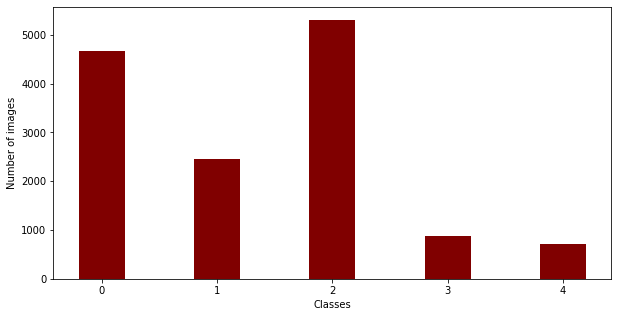

In [ ]:
my_Path = '/content/drive/MyDrive/ML Project/Diabetic Retinopathy/Fungus of Retina/'
freq = []
classes=[0,1,2,3,4]
for i in range(5):
  cl = str(i)
  freq.append(len(os.listdir(my_Path + cl + '/')))
print(freq)
data = {'0':freq[0], '1':freq[1], '2':freq[2],
        '3':freq[3], '4': freq[4]}
severity = list(data.keys())
count = list(data.values())
  
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(severity, count, color ='maroon',
        width = 0.4)
plt.xlabel("Classes")
plt.ylabel("Number of images")


## Blood vessel extraction 

In [ ]:
def _filter_kernel_mf_fdog(L, sigma, t = 3, mf = True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')
    ctr_x = dim_x / 2 
    ctr_y = int(dim_y / 2.)
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (np.sqrt(2 * np.pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2
    def k_fun(x):
        return sqrt_w_pi_sigma * np.exp(-x * x / two_sigma_sq)
    def k_fun_derivative(x):
     return -x * sqrt_w_pi_sigma * np.exp(-x * x / two_sigma_sq)
    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv.flip(kernel, -1) 



In [ ]:
def gaussian_matched_filter_kernel(L, sigma, t = 3):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, True)



## Extracted blood vessel



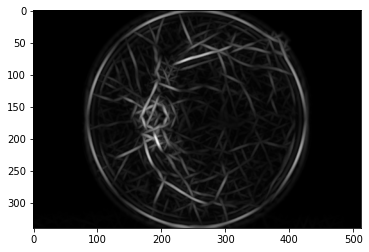

## Applying k-means clusetering for blood vessels 

In [ ]:
def kmeans(img):
  Z = img.reshape((-1,1))   
# convert to np.float32
  Z = np.float32(Z)
  k=cv.KMEANS_PP_CENTERS
# define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  ret,label,center=cv.kmeans(Z,K,None,criteria,10,k)
# Now convert back into uint8, and make original image
  center = np.uint8(center)
  res = center[label]
  res2 = res.reshape((img.shape))
  return res2

## Applying the methods on images

In [ ]:
def image_preprocessing(img):
  img_new = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  img_gray = cv.cvtColor(img_new, cv.COLOR_RGB2GRAY)
  clahe = cv.createCLAHE(clipLimit = 5)
  clahe_equalized_hist = clahe.apply(img_gray) + 50
  sample_image_transform = pywt.dwt2(clahe_equalized_hist,'Haar')[0]
  # blur = cv.GaussianBlur(sample_image_transform.astype('float32'),(5,5),0)
  # blur = image.img_to_array(blur,dtype ="uint8")
  # ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
  # plt.imshow(th3, cmap = "gray")
  # plt.show()
  filtered = applyFilters(sample_image_transform,bank_gf)
  k_mean = kmeans(filtered)
  plt.imshow(k_mean,cmap = 'gray')
  return k_mean

In [ ]:
def conversion(folder_path):
  for i in range(5):
    curCls = str(i)
    try:
      if not os.path.exists(folder_path +'processed_new/' + curCls):
        os.makedirs(folder_path +'processed_new/' + curCls)
    except OSError as err:
        print(err)
   
    for filename in os.listdir(folder_path + curCls + '/'):
        path_to_save = folder_path +'processed_new/' + curCls + '/'
        if filename.endswith(".jpeg"):
          img = cv.imread(folder_path +curCls+'/'+filename,0)
          processed_img = image_preprocessing(img)
          cv.imwrite(path_to_save + filename,processed_img)
          
myPath="/content/drive/MyDrive/ML Project/Diabetic Retinopathy/Fungus of Retina/"

conversion(myPath)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Splitting into train test

In [ ]:
# # # Creating Train / Val / Test folders (One time use)

folder_path = '/content/drive/MyDrive/ML Project/Diabetic Retinopathy/Fungus of Retina/'

def train_test_split(root_dir):

# making test/train directory for each class name 
  for i in range(5):
    currentCls = str(i) 
    os.makedirs(root_dir +'train' + currentCls)
    os.makedirs(root_dir +'test' + currentCls)

  # Creating partitions of the data after shuffeling
    src = root_dir + currentCls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)*0.8)])

    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print(f'Total images for class {currentCls}: ', len(allFileNames))
    print(f'Training {currentCls}: ', len(train_FileNames))
    print(f'Testing {currentCls}: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir + "train/" + currentCls)

    for name in test_FileNames:
        shutil.copy(name, root_dir + "test/" + currentCls)